In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window, stft
from scipy.linalg import solve_toeplitz
import sounddevice as sd

from util import my_windowing, compute_stft, plot_log_magnitude
from filteradaptively import filter_adaptively


%matplotlib widget
plt.close("all")

file = "Audio/female8khz.wav"

In [2]:
y, sr = librosa.load(file, sr=None)
print(f"Sampling Rate: {sr} Hz")
print(f"Signal Length: {len(y) / sr} s")

Sampling Rate: 8000 Hz
Signal Length: 2.25 s


**2.1 Segmentation**

Before we start to analyze the speech signal, we first split the signal into overlapping segments with a length of N samples. Each segment overlaps with the previous frame by $L = N−R$ samples, like depicted in Fig. 1. Use a segment length of 32 ms and a segment shift of 8 ms. You may use the function `m_frames, v_time_frame = my_windowing(x, fs, N, R)` from the first exercise session.

*Why do we segment the signal prior to analysis instead of processing the whole signal at once?*

Time-Frequency Analysis:

- Techniques like STFT require dividing the signal into frames.
- Allows analysis of frequency content changes over time.
- Crucial for understanding and processing speech signals.

Dynamic Range:

- Speech signals have varying dynamic ranges and temporal variations.
- Segmenting isolates these variations for separate analysis.
- Leads to better feature extraction and enhancement.

*Is a segment length of 32 ms appropriate? Why or why not?*

 A 32 ms window provides a good balance between time resolution and frequency resolution. Shorter windows offer better time resolution but poorer frequency resolution, while longer windows offer better frequency resolution but poorer time resolution. A 32 ms window is a common compromise used in speech processing.



In [3]:
frame_length = 32
frame_shift = 8
m_frames, v_time_frame = my_windowing(y, sr, 32, 8)

print(f"Split the signal into {m_frames.shape[0]} frames with {m_frames.shape[1]} saples each.")

Split the signal into 282 frames with 256 saples each.


**2.2 Signal power**

In the following, we want to estimate a set of parameters for each of the segments. We begin with creating a function named `compute_power` that takes a signal segment as an input variable and returns the signal power,

$$\sigma^2_x = \frac{1}{N} \sum^{N}_{n=1} x(n)^2$$

where $n$ is the sample index and $x(n)$ corresponds to the current signal segment. Compute the signal power for each segment and store it in a vector. Display the standard deviation ($\sqrt{\sigma^2_x} = \sigma_x$) together with the waveform of the speech signal in one plot.

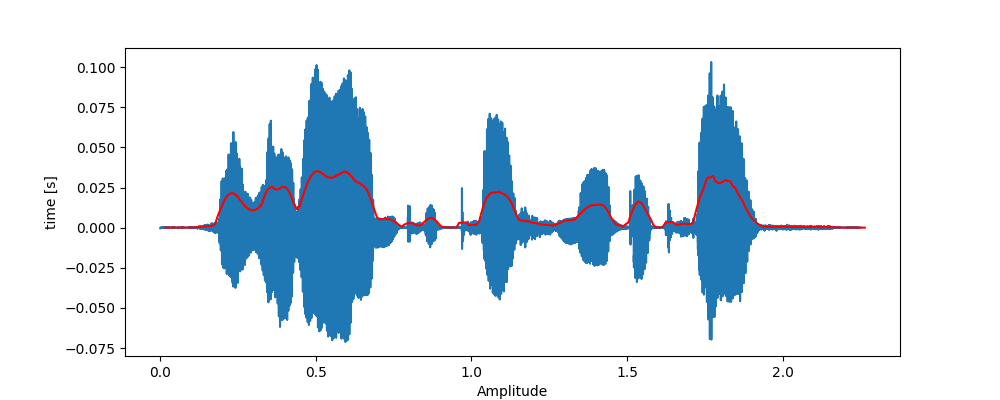

In [4]:
def compute_power(seg: np.ndarray) -> float:
    return (1/len(seg)) * np.sum(seg**2)

v_power = np.asarray([np.sqrt(compute_power(frame)) for frame in m_frames])

time = np.arange(0, len(y)) / sr
fig, ax1 = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(10)

ax1.set_ylabel("time [s]")
ax1.set_xlabel("Amplitude")

ax1.plot(time, y)
ax1.plot(v_time_frame, v_power, "r")

**2.3 Voiced / unvoiced decision**

Write another function, `is_voiced`, to also analyze if a segment is voiced or not. Here, we use a simple approach, which is counting the number of zero crossings within in one segment.

Definition:  
> The zero-crossing rate (ZCR) is the rate at which a signal changes from positive to zero to negative or from negative to zero to positive.

- Count the number of zero crossings in each segment and normalize them by the segment length $N$. Apply a threshold to decide if the segment is voiced or not. Try to find an appropriate value for the threshold that allows for a reliable classification. Do not expect it to be 100% perfect, but try your best.
- `is_voiced` should return 1 for voiced segments and 0 for unvoiced segments

Explanation:
- We use np.diff(np.sign(segment)) to find the points where the sign of the segment changes, indicating a zero crossing. np.sum(np.abs(...) > 0) counts these crossings.

In [5]:
def is_voiced(seg: np.ndarray, threshold: float = 0.3) -> int:
    zero_crossings = np.sum(np.abs(np.diff(np.sign(seg))) > 0)
    zero_crossing_rate = zero_crossings / len(seg)
    return 1 if zero_crossing_rate < threshold else 0

(282,)


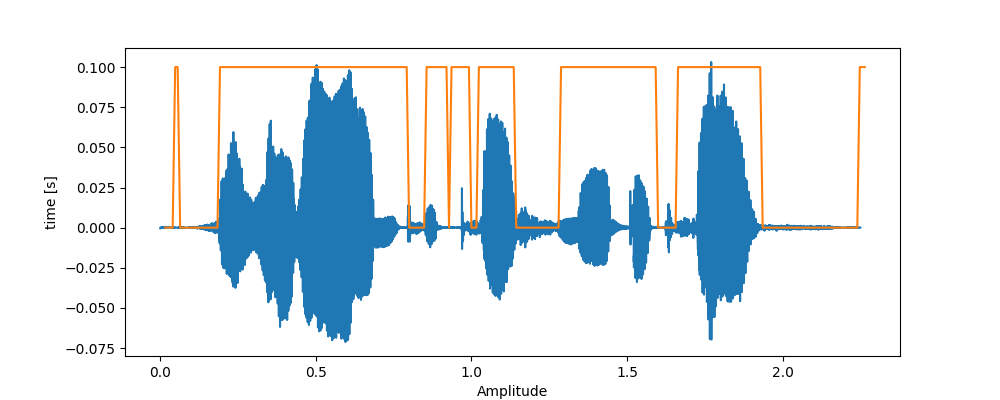

In [6]:
time = np.arange(0, len(y)) / sr

v_uv_frames = np.asarray([is_voiced(x, 0.3) for x in m_frames])
print(v_uv_frames.shape)

fig, ax1 = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(10)

ax1.set_ylabel("time [s]")
ax1.set_xlabel("Amplitude")

ax1.plot(time, y)
ax1.plot(v_time_frame, v_uv_frames*0.1)

# plot_log_magnitude(*compute_stft(y, sr, frame_length, frame_shift, get_window("hann", int(sr * frame_length / 1000), True)))

*Why might the number of zero crossings provide valuable information for the voiced/unvoiced decision?*

Voiced Sounds:
- Have a more regular, periodic waveform with fewer zero crossings.

Unvoiced Sounds:
- Have a more irregular, noisy waveform with more zero crossings.

Zero Crossings:
- Counting zero crossings helps distinguish between the regularity of voiced sounds and the irregularity of unvoiced sounds.

*In general: are all speech sounds either voiced or unvoiced? Can you think of other speech sounds? Examples?*
- Whispered Speech
- Clicks

**2.4 Fundamental frequency estimation**

In voiced sounds, the vocal cords periodically open and close. The frequency at which they open and close is called the fundamental frequency, $f_0$.

You have already implemented a method to estimate the fundamental frequency based on the autocorrelation function (ACF) in the first exercise session. We can now reuse it here. Put your estimator into a Python function of the form `def estimate_f0(m_frames: np.ndarray, fs: int) -> [np.ndarray (v_f0_estimates)]` where `v_f0_estimates` is a vector containing the fundamental frequency estimates in [Hz] for each signal segment.


In [7]:
def estimate_f0(m_frames: np.ndarray, fs: int) -> np.ndarray:
    fundamental_freqs = []
    
    # Step b: Compute ACF for each frame and step d: Estimate fundamental frequency
    for frame in m_frames:
        # ACF via convolution
        acf = np.convolve(frame, frame[::-1], mode='full')
        
        # Step c: Focus on non-negative lags
        acf = acf[len(acf)//2:]
        
        # Convert frequency range to corresponding lag range
        min_lag = fs // 400  # Maximum frequency
        max_lag = fs // 80   # Minimum frequency
                
        # Step d: Identify peak within the lag range corresponding to 80 Hz to 400 Hz
        peak_lag = np.argmax(acf[min_lag:max_lag]) + min_lag
        fundamental_freq = fs / peak_lag
        
        fundamental_freqs.append(fundamental_freq)
    
    return np.asarray(fundamental_freqs)

Plot your fundamental frequency estimate together with the spectrogram of the clean speech. For this, the y-axis needs to be in Hz. Use the function `compute_stft` from exercise 2 to compute the spectrogram.

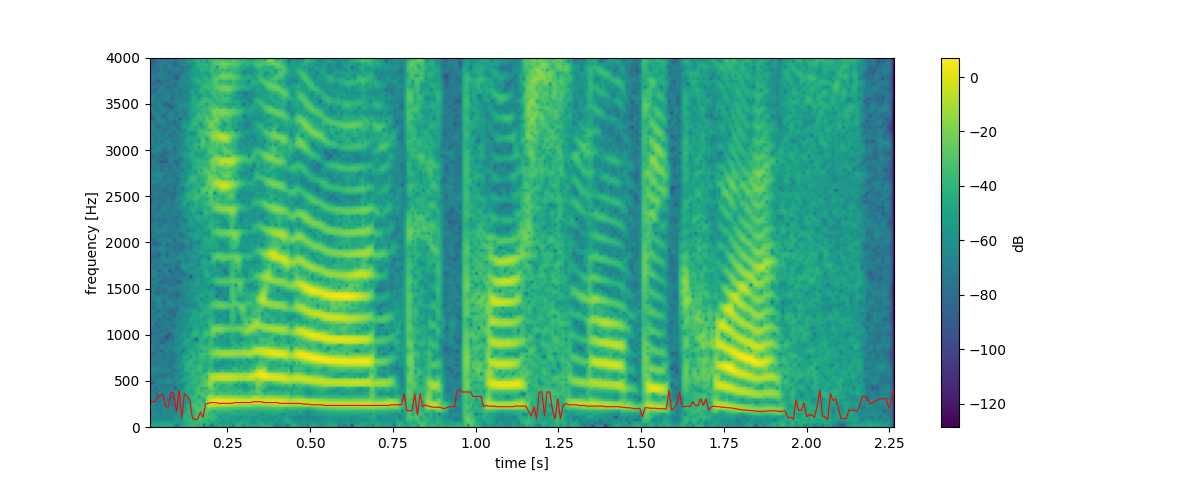

In [8]:
m_stft, v_freq, v_time = compute_stft(y, sr, frame_length, frame_shift, get_window("hann", int(sr * frame_length / 1000), True))
v_f0_estimates = estimate_f0(m_frames, sr)

fig = plt.figure()
fig.set_figwidth(12)
ax = fig.add_subplot(111)
ax.set_ylabel("frequency [Hz]")
ax.set_xlabel("time [s]")
im = ax.imshow(
    10 * np.log10(np.maximum(np.square(np.abs(m_stft.T)), 10 ** (-15))),
    cmap="viridis",
    origin="lower",
    extent=[v_time[0], v_time[-1], v_freq[0], v_freq[-1]],
    aspect="auto",
)
ax.plot(v_time, v_f0_estimates, "r", linewidth=0.8)
colorbar = fig.colorbar(im, orientation="vertical", pad=0.05)
colorbar.set_label("dB")

**2.5 Linear prediction coefficients / linear predictive coding**

In the lecture, you learned that the form of the vocal tract is crucial to speech production and that it can be modeled by concatenating sections of lossless tubes. This model can well be described in terms of reflection coefficients for each section border. A closely related description can be obtained in terms of an all-pole filter, i.e. its filter coefficients, known as the linear prediction coefficients (LPCs). A common, since very efficient, method to compute the LPCs is the so-called Levinson-Durbin algorithm. Although not necessary at this point, it is worth mentioning that LPCs can be transformed into reflection coefficients and vice versa. This will come in handy in Section 4.
- Shortly outline the Source-Filter-Model for speech production.
- Compute the LPCs of the signal segments based on the code you have from exercise session three. For that, write a Python function `def compute_lpc(m_frames: np.ndarray, M: int)->[np.ndarray (m_lpc)]` that returns the LP coefficients of each signal segment in the matrix `m_lpc`, which is of size `[num_frames x M]`.
- Choose a suitable model order $M$ for linear prediction for a signal with an audio bandwidth of 4 kHz. Give reasons for your choice.

Model order $M=12$, because TODO

Now we have all parameters we need to decently describe our speech signal. In the next section, we will try to reconstruct the actual waveform of the speech signal based only on this parameter set.

In [9]:
# Exercise 3
def get_coefficients(signal: np.ndarray, lpc_order: int = 12) -> np.ndarray:
    # compute the autocorrelation vector
    phi_full = np.correlate(signal, signal, mode="full")  # mode "valid" | "full"
    # autocorrelation is symmetric, we only need one half
    center = len(phi_full) // 2
    phi = phi_full[center:center + lpc_order + 1]
    # The right-hand side vector is the remaining part
    b = phi[1:]
    # Solve for the LPC coefficients
    a = solve_toeplitz((phi[:-1], phi[:-1]), b)

    return -a

def compute_lpc(m_frames: np.ndarray, M: int = 12) -> np.ndarray:
    return np.asarray([get_coefficients(frame, M) for frame in m_frames])


**3 LPC-vocoder: synthesis**

In this section, lets assume that the speech signal is recorded and analyzed on one device, the transmitter, and only the parameters, but not the signal itself, are send to another device, the receiver. Now we want to reconstruct the speech signal only from the provided parameters with the help of a LPC-vocoder. We will proceed step-by-step   incorporating one parameter a time, analyzing the influence of each of the parameters to the overall result.

**3.1 LPCs and constant excitation signal** 

First, we want to utilize only the LPCs, modeling the influence of the vocal tract. For this, we filter a stationary
excitation signal `e(n)` with the LPC coefficients.

- Create two excitation signals
    1. unvoiced: white Gaussian noise via np.random.randn
    2. voiced: pulse train with a frequency of 100 Hz.

        Tip: `voiced_ex = np.zeros(num_samples)` and `voiced_ex[::fund_period_in_samples] = 1`
        
- Segment the excitation signal e(n) into non-overlapping frames of length R (the same segmentation will be used
implicitly in all upcoming experiments)
- Filter each segment with the corresponding LPCs using the function filter_adaptively provided by the package
downloaded from STiNE. It allows for improved adaptive filtering by introducing a filter state storing necessary
information of the last filtering. It can be used as 

    `segment_out , filter_state = filter_adaptively(np.array ([1]), LPCs, segment, filter_state_in)`.

    Note that `filter_state` from the last segment is used as an input parameter. It is then modified by `filter_adaptively` and the new `filter_state` is returned.
- Put together the separate segments to obtain the whole signal.
- Listen to both of the signals, voiced only and unvoiced only. Can you understand what is said?
- Display the spectrogram of the two synthesized signals.


In [10]:
# Exercise 3
def get_coefficients(signal: np.ndarray, lpc_order: int = 12) -> np.ndarray:
    # compute the autocorrelation vector
    phi_full = np.correlate(signal, signal, mode="full")  # mode "valid" | "full"
    # autocorrelation is symmetric, we only need one half
    center = len(phi_full) // 2
    phi = phi_full[center:center + lpc_order + 1]
    # The right-hand side vector is the remaining part
    b = phi[1:]
    # Solve for the LPC coefficients
    a = solve_toeplitz((phi[:-1], phi[:-1]), b)
    return -a

def compute_lpc(m_frames: np.ndarray, sr: int, M) -> np.ndarray:
    # Get Hann window
    frame_length = len(m_frames[0])
    v_analysis_window = get_window("hann", frame_length, True)
    # m_frames *= v_analysis_window

    # return np.asarray([get_coefficients(frame, M) for frame in m_frames])
    return np.asarray([librosa.lpc(frame, order=M) for frame in m_frames])

# Wir nutzen die Sampling Rate und Länge des Input-Signals
signal_length_s = len(y) / sr 
num_samples = int(sr * signal_length_s)
M = 16  # LPC order

print(f"Sampling Rate: {sr} Hz")
print(f"Signal Length: {signal_length_s} s")
print(f"Total Samples: {num_samples}")
print(f"Fundamental Period in Samples: {sr // 100}")

# Generate excitation signals
def create_excitation_signals(num_samples: int, sr: int) -> tuple[np.ndarray, np.ndarray]:
    # Unvoiced excitation: White Gaussian noise
    unvoiced_ex = np.random.randn(num_samples)
    
    # Voiced excitation: Pulse train with a frequency of 100 Hz
    fund_freq = 100  # Fundamental frequency in Hz
    fund_period = int(sr / fund_freq)  # Fundamental period in samples
    
    voiced_ex = np.zeros(num_samples)
    # wenn fund_period = 80, wird hier jedes 80. sample = 1 gesetzt
    voiced_ex[::fund_period] = 1
    
    return unvoiced_ex, voiced_ex

unvoiced_ex, voiced_ex = create_excitation_signals(num_samples, sr)

# Split the excitation signals into non-overlapping segments
# R = 8 da wir das originale Signal in 279 Frames mit je 64 Samples gesplittet haben
# Ohne Overlap können wir mit 8 ms frame length/shift 
R = 8

m_frames_u, v_time_frame_u = my_windowing(unvoiced_ex, sr, R, R)
m_frames_v, v_time_frame_v = my_windowing(voiced_ex, sr, R, R)

# Print shapes of the segmented excitation signals to verify
print("\nUnvoiced segments shape:", m_frames_u.shape)
print("Voiced segments shape:", m_frames_v.shape)

# Compute LPC coefficients
m_lpc_u = compute_lpc(m_frames_u, sr, M)
m_lpc_v = compute_lpc(m_frames_v, sr, M)

def synthesize_signal(m_frames, m_lpc):
    filtered_frames = []
    filter_state = None

    assert len(m_frames) == len(m_lpc)
    num_frames = len(m_frames)

    for i in range(num_frames):
        segment_out, filter_state = filter_adaptively(
            np.array([1]), 
            m_lpc[i], 
            m_frames[i], 
            filter_state
        )
        filtered_frames.append(segment_out)
    
    # Put together the separate segements and return
    return np.concatenate(filtered_frames)

synthesized_u = synthesize_signal(m_frames_u, m_lpc_u)
synthesized_v = synthesize_signal(m_frames_v, m_lpc_v)

Sampling Rate: 8000 Hz
Signal Length: 2.25 s
Total Samples: 18000
Fundamental Period in Samples: 80

Unvoiced segments shape: (282, 64)
Voiced segments shape: (282, 64)


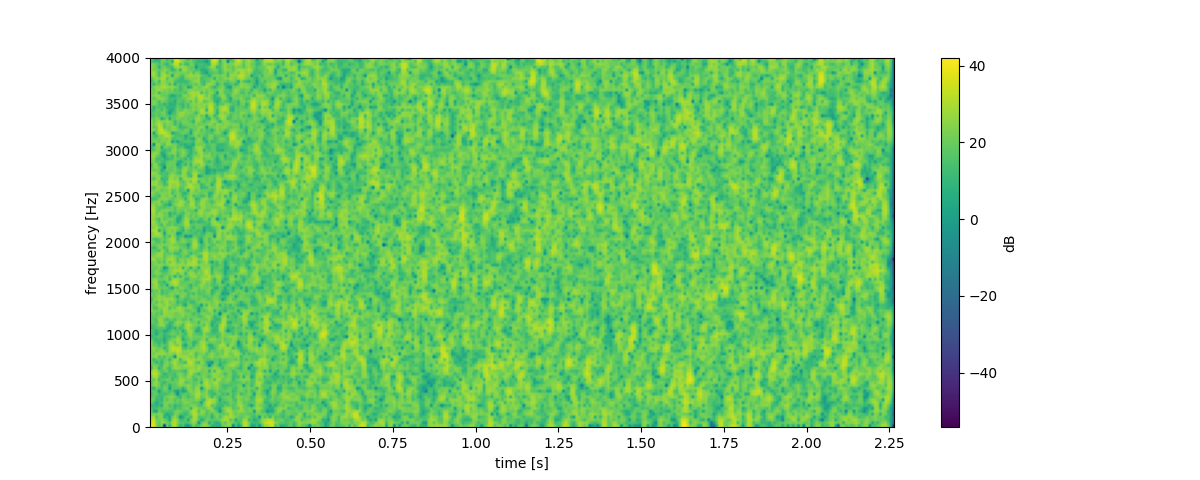

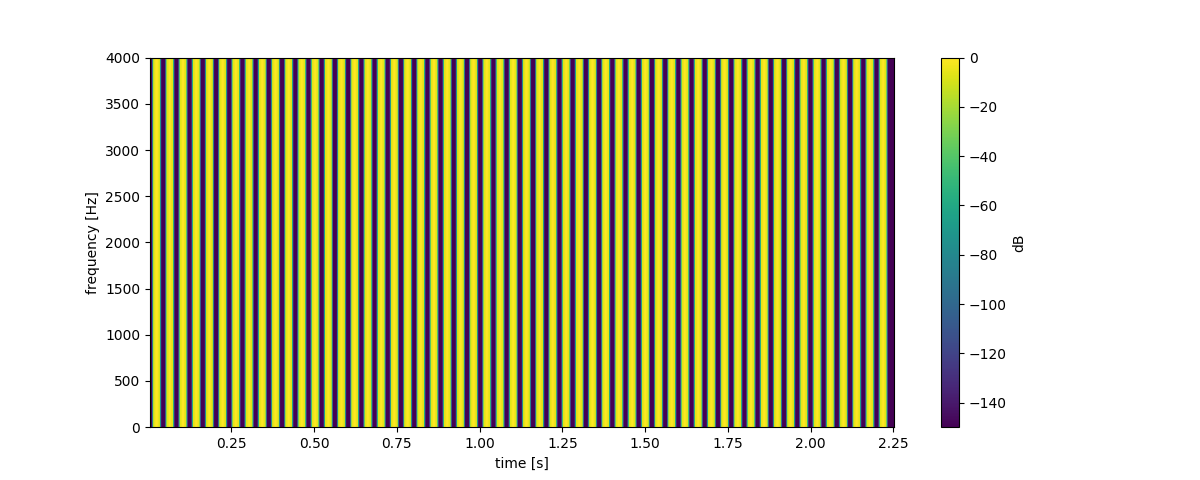

In [11]:
# voiced
plot_log_magnitude(*compute_stft(synthesized_u, sr, frame_length, frame_shift, get_window("hann", int(sr * frame_length / 1000), True)))
# unvoiced
plot_log_magnitude(*compute_stft(synthesized_v, sr, frame_shift, frame_shift, get_window("hann", int(sr * frame_shift / 1000), True)))

In [12]:
# Listen to the signals (requires sounddevice)
print("Playing unvoiced synthesized signal...")
sd.play(synthesized_u, sr)
sd.wait()

print("Playing voiced synthesized signal...")
sd.play(synthesized_v, sr)
sd.wait()

Playing unvoiced synthesized signal...
Playing voiced synthesized signal...


**3.2 Voiced/unvoiced excitation**

Now we want to go a step further and switch between the voiced and unvoiced excitation signal based on the voiced/unvoiced parameter extracted from the speech signal in Section 2. Use the same excitation signals as in the previous experiment, but use the pulse train for voiced sounds and the noise for unvoiced sounds. Don’t forget to still apply the linear prediction filter. Listen to the resulting signal. If you encounter perceivable errors in the voiced/unvoiced decision, try to adapt the threshold in Section 2.3, reanalyze the speech signal and try the new parameter set.

In [13]:
def synthesize_signal2(v_uv_frames, m_frames_u, m_lpc_u, m_frames_v, m_lpc_v):
    filtered_frames = []
    filter_state = None
    num_frames = len(v_uv_frames)

    for i in range(num_frames):
        if v_uv_frames[i]:
            sel_frame = m_frames_v[i]
            sel_lpc = m_lpc_v[i]
        else:
            sel_frame = m_frames_u[i]
            sel_lpc = m_lpc_u[i]

        segment_out, filter_state = filter_adaptively(
            np.array([1]), 
            sel_lpc, 
            sel_frame, 
            filter_state
        )
        filtered_frames.append(segment_out)
    
    # Put together the separate segements and return
    return np.concatenate(filtered_frames)

# TODO: v_uv_frames und die frame-matritzen haben nicht genau die gleiche länge (279 != 282) -> warum ist das so? 
synthesized_signal = synthesize_signal2(v_uv_frames, m_frames_u, m_lpc_u, m_frames_v, m_lpc_v)

In [ ]:
sd.play(synthesized_signal, sr)
sd.wait()

**3.3 Amplitude modulation**

As the next step, we also incorporate the signal power into our signal synthesis.
- Modify the amplitude of each signal segment by means of a real-valued gain $g$ so that it has the same power as the corresponding input speech signal segment in Section 2.
- How do you have to choose the gain $g$ to achieve this?
- Listen to the synthesized signal. What is the improvement achieved by applying $g$?
- Display the spectrogram of the synthesized signal, compare it to the spectrogram of the last section and explain differences.

In [14]:
def apply_gain(m_frames: np.ndarray, v_power: np.ndarray) -> np.ndarray:
    for i in range(len(v_power)):
        frame_energy = max(np.sqrt((compute_power(m_frames[i]))), 10**-15)
        gain = v_power[i] / frame_energy
        m_frames[i] *= gain
    return m_frames

m_frames_v_mod = apply_gain(m_frames_v, v_power)
m_frames_u_mod = apply_gain(m_frames_u, v_power)

synthesized_signal = synthesize_signal2(v_uv_frames, 
    m_frames_u_mod, 
    m_lpc_u, 
    m_frames_v_mod, 
    m_lpc_v
)

In [ ]:
sd.play(synthesized_signal, sr)
sd.wait()

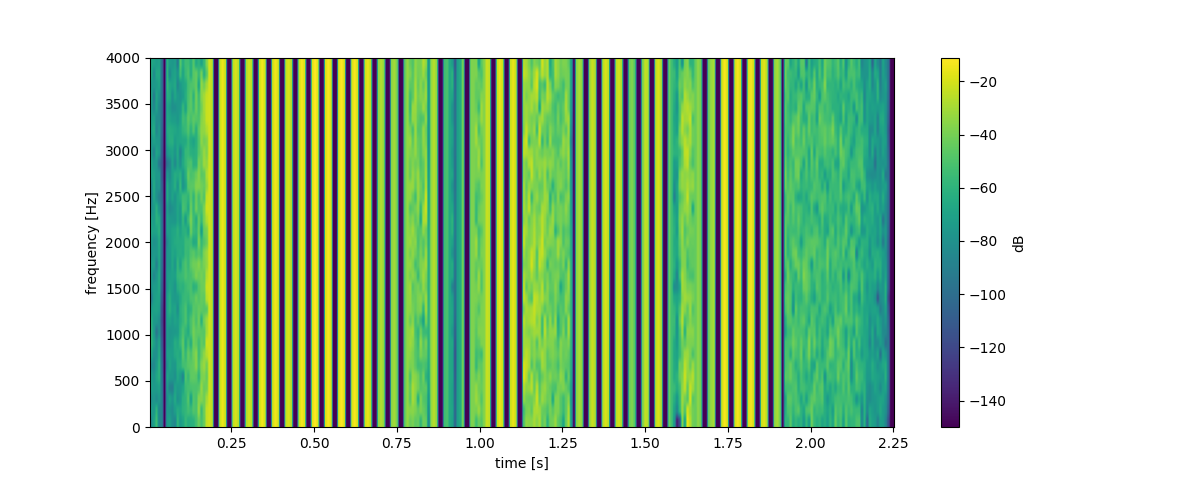

In [15]:
plot_log_magnitude(*compute_stft(synthesized_signal, sr, frame_shift, frame_shift, get_window("hann", int(sr * frame_shift / 1000), True)))

**3.4 Variable f0**

We already modeled the vocal tract, incorporated the signal power, and switched between voiced and unvoiced excitation signals. However, during voiced sounds the fundamental frequency is still speaker independent and constant. Therefore, we now incorporate the fundamental frequency estimates obtained from the speech signal.

- For unvoiced sounds, just keep on using white Gaussian noise.
- For voiced segments, things become a bit more complicated to implement. Instead of the constant pitch signal, we now have to adapt the distance between two pulses based on the fundamental frequency estimate. Further we have to take care that we avoid inconsistencies between adjacent segments due to changes in the fundamental frequency.

    - Create a counter that you increase for every sample of a voiced segment.
    - Test if the counter is larger than the current fundamental period in samples.
    - Every time this is the case, set the counter to zero and insert a pulse into the excitation signal at the corresponding sample of the segment.
    - Keep the value of the counter also if the segment ends, do not reset it to zero.
    
- As before, chose the excitation signal based on your voiced/unvoiced decision and apply the linear prediction filter and gain $g$.
- Listen to the resulting signal. Does the signal quality improve?
- Now that we incorporated all of our parameters, do you still hear artifacts or errors in the synthesized speech signal? If this is the case, try to find and explain reasons for that.
- Display the spectrogram of the synthesized signal, compare it to the one of the last section, and explain differences.

A block diagram of the final synthesis stage is depicted in Fig. 2.


In [16]:
f_freq_samples = sr / v_f0_estimates
frame_length_samples = m_frames_v.shape[1]

e_voiced = np.zeros(num_samples)

counter = 0
for i in range(len(e_voiced)):
    counter += 1
    idx = int(np.ceil(i / frame_length_samples) - 1)
    if counter >= f_freq_samples[idx]:
        counter = 0
        e_voiced[i] = 1



IndexError: index 282 is out of bounds for axis 0 with size 282